Group Members:

Sara Khosravi 97101586

Ali Ghadirli 96105983

Mohsan Gehghankar 97105983

In [1]:
!pip install eli5

     |████████████████████████████████| 112kB 7.3MB/s 


In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
from sklearn.metrics import confusion_matrix
import eli5

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
os.environ['KAGGLE_CINFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle/sarcasm"

In [ ]:
import nltk

nltk.download('punkt')
nltk.download('wordnet')
import pickle

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
%cd /content/gdrive/MyDrive/Kaggle/sarcasm

/content/gdrive/MyDrive/Kaggle/sarcasm


In [ ]:
!unzip -q 'projectPhase2_dataset.zip'

unzip:  cannot find or open projectPhase2_dataset.zip, projectPhase2_dataset.zip.zip or projectPhase2_dataset.zip.ZIP.


In [ ]:
os.listdir()

['sarcasm_train_set.csv', 'sarcasm_test_set.csv', 'model.bin']

# EDA

ابتدا داده‌ها را لود می‌کنیم و نگاهی به فیچرهای آن می‌اندازیم

In [ ]:
data = pd.read_csv('sarcasm_train_set.csv')

In [ ]:
data.head()

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?


همانطور که مشاهده می‌شود فقط ستون کامنت تعداد خیلی کمی داده نال دارد که به دلیل کم بودن آن‌ها، این سمپل‌ها را حذف می‌کنیم.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808998 entries, 0 to 808997
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unnamed: 0      808998 non-null  int64 
 1   label           808998 non-null  int64 
 2   comment         808960 non-null  object
 3   author          808998 non-null  object
 4   subreddit       808998 non-null  object
 5   score           808998 non-null  int64 
 6   ups             808998 non-null  int64 
 7   downs           808998 non-null  int64 
 8   date            808998 non-null  object
 9   created_utc     808998 non-null  object
 10  parent_comment  808998 non-null  object
dtypes: int64(5), object(6)
memory usage: 67.9+ MB


In [ ]:
data.dropna(subset=['comment'], inplace=True)

In [ ]:
data.shape

(808960, 11)

همانطور که در زیر دیده می‌شود دیتاست به خودی خود متعادل است


1    404735
0    404225
Name: label, dtype: int64


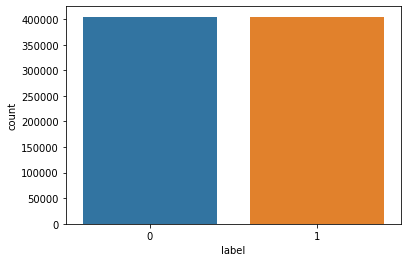

In [ ]:
print(data['label'].value_counts())
ax = sns.countplot(x="label", data=data)


In [ ]:
type(data['created_utc'][0])

str

در این قسمت یک فیچر جدید که نشان‌دهنده سال اتفاق افتادن کامنت است را اضافه می‌کنیم.

In [ ]:
data['date'] = pd.to_datetime(data['date'], yearfirst=True)
data['year'] = data['date'].apply(lambda d: d.year)
data.head(10)

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,year
0,0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10-01,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",2016
1,1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11-01,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,2016
2,2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09-01,2016-09-22 21:45:37,They're favored to win.,2016
3,3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10-01,2016-10-18 21:03:47,deadass don't kill my buzz,2016
4,5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09-01,2016-09-02 10:35:08,do you find ariana grande sexy ?,2016
5,6,0,Trick or treating in general is just weird...,only7inches,AskReddit,1,-1,-1,2016-10-01,2016-10-23 21:43:03,What's your weird or unsettling Trick or Treat...,2016
6,7,0,Blade Mastery+Masamune or GTFO!,P0k3rm4s7,FFBraveExvius,2,-1,-1,2016-10-01,2016-10-13 21:13:55,Probably Sephiroth. I refuse to taint his grea...,2016
7,8,0,"You don't have to, you have a good build, buy ...",SoupToPots,pcmasterrace,1,-1,-1,2016-10-01,2016-10-27 19:11:06,What to upgrade? I have $500 to spend (mainly ...,2016
8,9,0,I would love to see him at lolla.,chihawks,Lollapalooza,2,-1,-1,2016-11-01,2016-11-21 23:39:12,Probably count Kanye out Since the rest of his...,2016
9,10,0,I think a significant amount would be against ...,ThisIsNotKimJongUn,politics,92,92,0,2016-09-01,2016-09-20 17:53:52,I bet if that money was poured into college de...,2016


یک دیتافریم جدید که درست می‌کنیم که در حقیقت ستون اول نشان‌دهنده تعداد کامنت‌های کنایه‌آمیز و ستون دوم درصد کامنت‌های کنایه‌آمیز است که همانطور که مشاهده می‌شود تعداد کامنت‌ی کنایه‌امیز به طور کلی زیاد شده اما درصد آن‌ها کمتر می‌شود.

In [ ]:
by_year = data.groupby('year')['label'].agg([np.sum, np.mean])
by_year

,sum,mean
year,,
2009,855,0.583220
2010,2372,0.565705
2011,5594,0.547626
2012,11677,0.535078
2013,27386,0.538046
2014,58869,0.535105
2015,119577,0.520917
2016,178405,0.468502


 نمودار زیر درصد کامنت‌های کنایه‌آمیز را نشان می‌دهد که به مرور زمان کمتر شده و به این دلیل که و

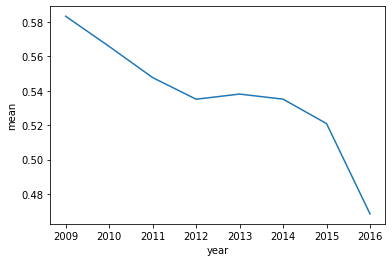

In [ ]:
sns.lineplot(data=by_year, x="year", y="mean")


نمودار زیر تعداد کامنت‌های کنایه‌آمیز را نشان می‌دهد که بر اساس سال بیشتر شده که بخاطر گسترش استفاده از این شبکه اجتماعی طبیعی است

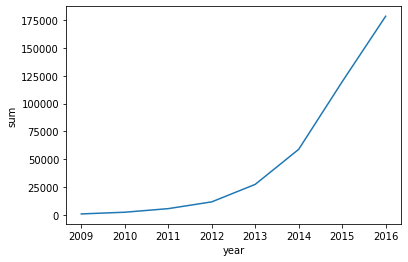

In [ ]:
sns.lineplot(data=by_year, x="year", y="sum")

یک دیتافریم درست می‌کنیم که تعداد و اینکه چند درصد کامنت‌های نویسنده‌ها کنایه‌آمیز است. همانطور که مشاهده می‌شود به تعداد زیر نویسنده متمایز داریم و در دیتافریم زیر نیز نویسنده‌هایی که بیشترین کامنت کنایه‌آمیز را داشته‌اند مشاهده می‌کنیم.

In [ ]:
print(len(data['author'].unique()))
by_author = data.groupby('author')['label'].agg([np.sum, np.mean]).reset_index()
by_author_sorted = by_author.sort_values('sum', ascending=False)
by_author_mean_sorted = by_author.sort_values('mean', ascending=False)
by_author_sorted.head()

249286


,author,sum,mean
14488,Biffingston,332,0.497006
82642,NeonDisease,177,0.526786
212505,pokemon_fetish,172,0.500000
106381,ShyBiDude89,148,0.486842
183066,ivsciguy,144,0.510638


نمودار زیر هم تعداد کامنت‌های کنایه‌آمیز افراد را نشان می‌دهد.

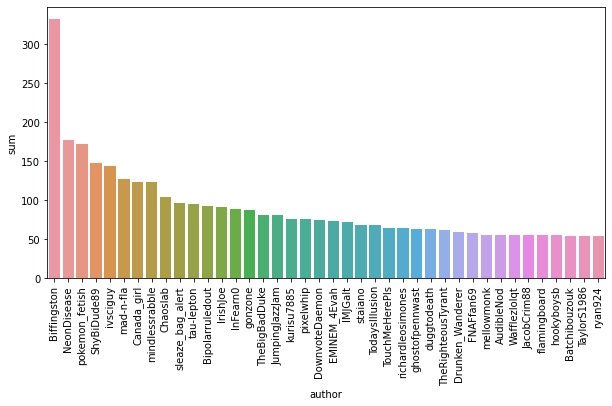

In [ ]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data=by_author_sorted[:40], x='author', y='sum')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

نمودار زیر نیز درصد کامنت‌های کنایه‌آمیز  صد نفر اول بر اساس این شاخص را نشان می‌دهد و همانطور که در جدول زیرین آن مشاهده می‌شود حدود ۲۸ هزار نفر یک کامنت داشته‌اند که همان کامنت کنایه‌آمیز بوده است. بنابراین با توجه به این موضوع و اینکه به طور کلی اگر بخواهیم مدلی داشته باشیم که بتواند کنایه‌آمیز بودن کامنت‌ها را متوجه بشود، اسم کاربران فقط درصورتی که نفراتی وجود داشته باشند که خیلی کنایه‌آمیز کامنت بگذارند و فقط بر روی آن‌ها شاید بتواند تاثیر بگذارد بنابراین بنظر می‌رسد استفاده از فیچر نویسنده در مدل کارآمد نیست

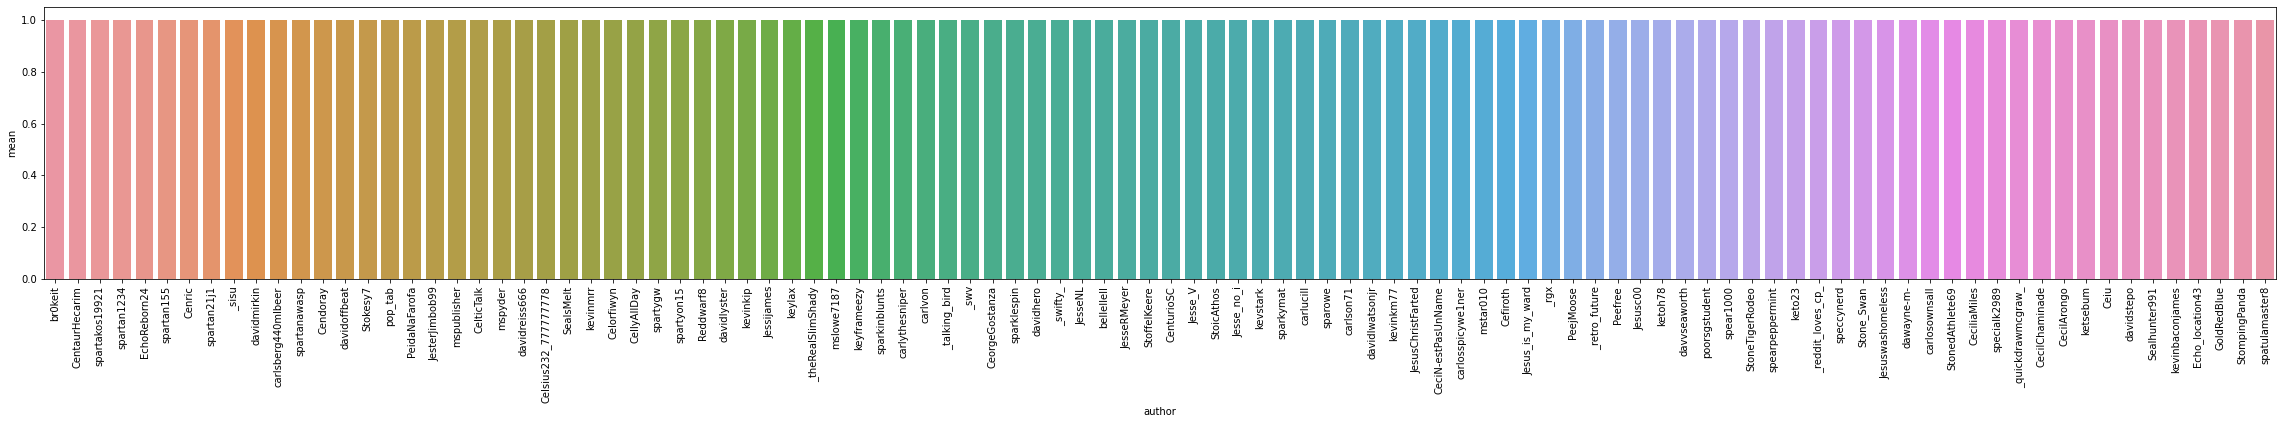

In [ ]:
plt.figure(figsize=(40, 5))
ax = sns.barplot(data=by_author_mean_sorted[:100], x='author', y='mean')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [ ]:
temp = by_author_mean_sorted[by_author_mean_sorted['sum']==1 ]
temp[temp['mean']==1].shape

(28785, 3)

همچنین تعداد کامنت‌های کنایه‌آمیز و درصد آن‌ها در جدول و نمودار زیر آمده است که نشان‌دهنده این است که ۳ سابردیت اول که مربوط به مسائل سیاسی و خبری هستند، سهم بیشتری در کامنت‌های کنایه‌آمیز دارند

In [ ]:
by_subreddit = data.groupby('subreddit')['label'].agg([np.sum, np.mean]).reset_index()
subreddit_sorted_by_sum = by_subreddit.sort_values('sum', ascending=False)
subreddit_sorted_by_sum.head()

,subreddit,sum,mean
537,AskReddit,21208,0.402307
11543,politics,19172,0.605521
13481,worldnews,13567,0.639923
10335,leagueoflegends,9193,0.546162
11361,pcmasterrace,8646,0.567584


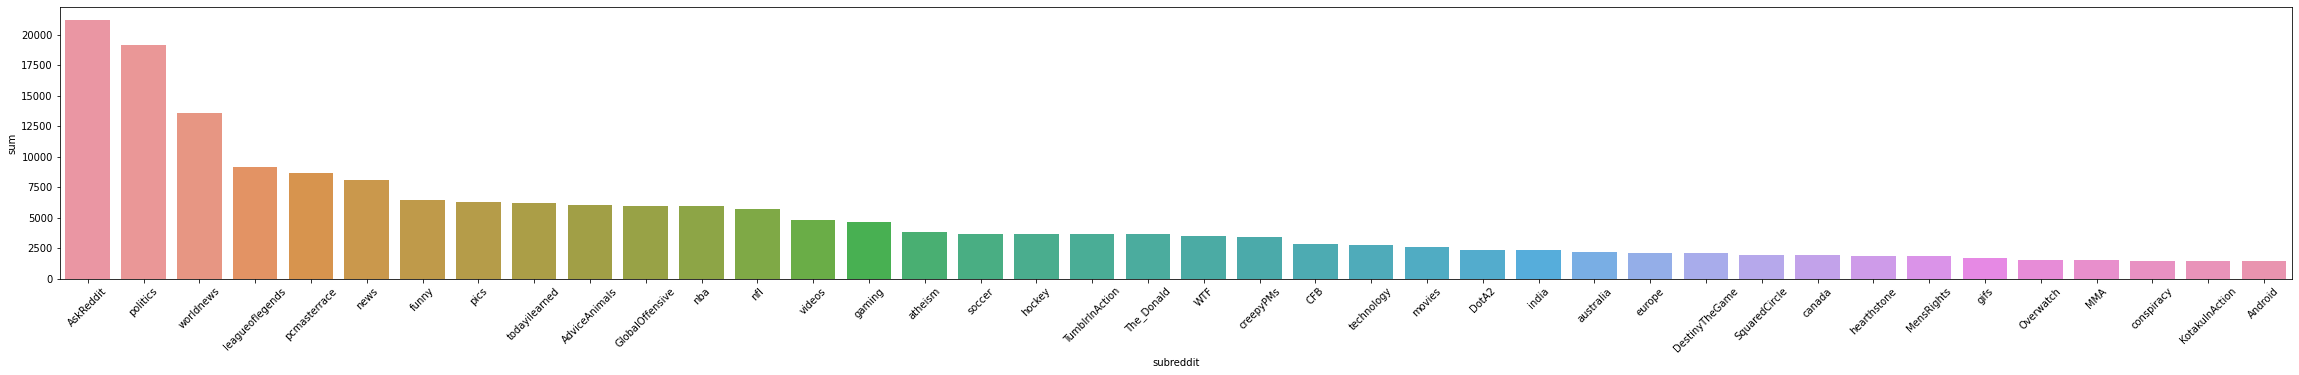

In [ ]:
plt.figure(figsize=(40, 5))
ax = sns.barplot(data=subreddit_sorted_by_sum[:40], x='subreddit', y='sum')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [ ]:
by_subreddit = data.groupby('subreddit')['label'].agg([np.sum, len]).reset_index().sort_values('len', ascending=False)
by_subreddit = by_subreddit.rename(columns={'sum':'sarcastic', 'len':'all_comments'})
by_subreddit['non_sarcastic'] = by_subreddit['all_comments'] - by_subreddit['sarcastic']
by_subreddit = by_subreddit[['subreddit', 'sarcastic', 'non_sarcastic', 'all_comments']]
by_subreddit.head()

,subreddit,sarcastic,non_sarcastic,all_comments
537,AskReddit,21208,31508,52716
11543,politics,19172,12490,31662
13481,worldnews,13567,7634,21201
10335,leagueoflegends,9193,7639,16832
11361,pcmasterrace,8646,6587,15233


همچنین میزان کل کامنت‌ها و بخش کنایه‌آمیز بودن آن‌ها مودار زیر برای سابردیت‌های اصلی مشخص شده است

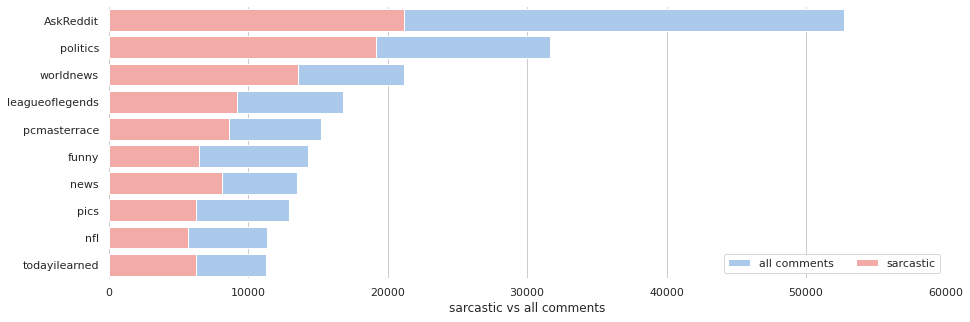

In [ ]:
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(15, 5))
sns.set_color_codes("pastel")
sns.barplot(x='all_comments', y='subreddit', data=by_subreddit[:10], label='all comments', color='b')

# sns.set_color_codes("muted")
sns.barplot(x="sarcastic", y="subreddit", data=by_subreddit[:10],
            label="sarcastic", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 60000), ylabel="",
       xlabel="sarcastic vs all comments")
sns.despine(left=True, bottom=True)

در نمودار نیز باکس‌پلات مربوط به طول کامنت‌های معمولی و کنایه‌آمیز را مشاهده می‌کنیم.

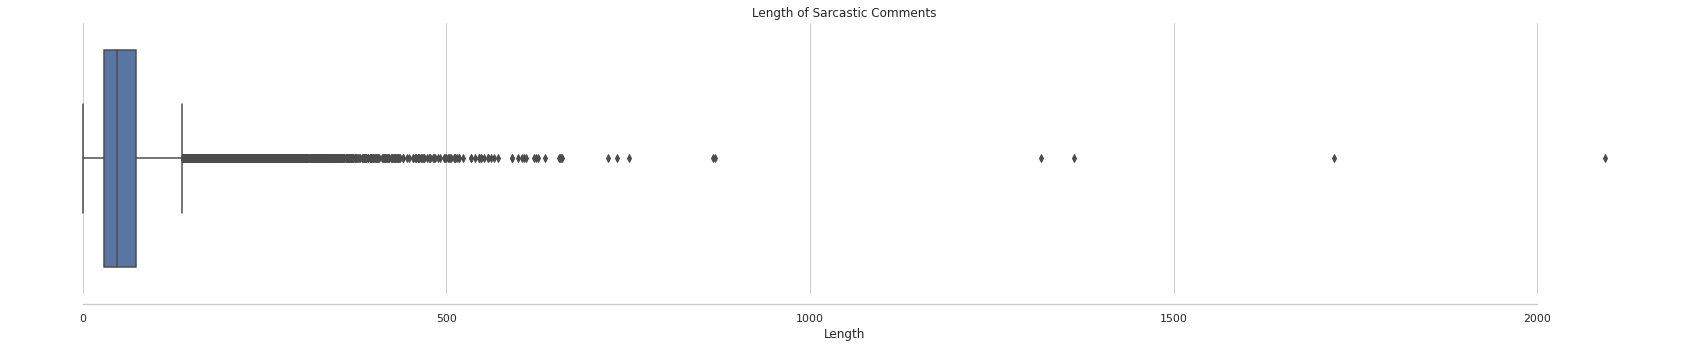

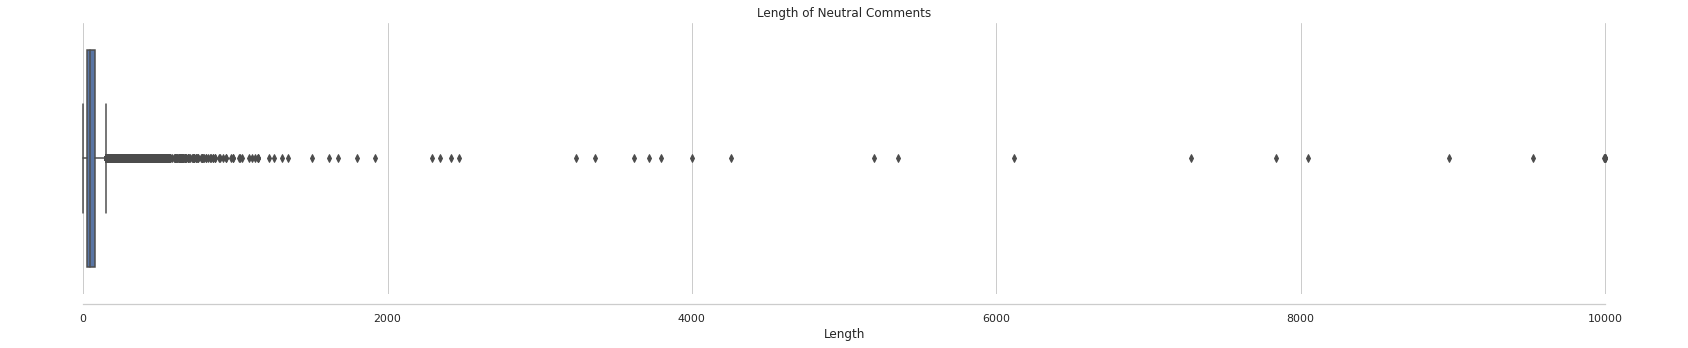

In [ ]:
f, ax = plt.subplots(figsize=(30, 5))

sns.boxplot(x= data.loc[data['label'] == 1, 'comment'].str.len()).set(title = 'Length of Sarcastic Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()
f, ax = plt.subplots(figsize=(30, 5))

sns.boxplot(x= data.loc[data['label'] == 0, 'comment'].str.len()).set(title = 'Length of Neutral Comments', xlabel = 'Length')
sns.despine(offset=10, trim=True)
plt.show()

همچنین در نمودار زیر هیستوگرام طول لگاریتمی کامنت‌ها را مشاهده می‌کنیم


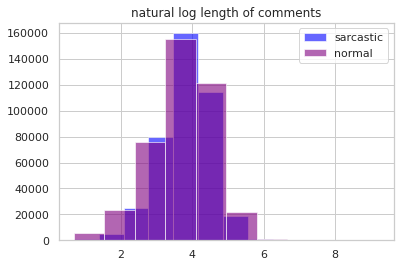

In [ ]:
data['log_comment'] = data['comment'].apply(lambda text: np.log1p(len(text)))
data[data['label']==1]['log_comment'].hist(alpha=0.6,label='sarcastic', color = 'blue')
data[data['label']==0]['log_comment'].hist(alpha=0.6,label='normal', color = 'purple')
plt.legend()
plt.title('natural log length of comments')
plt.show()

In [ ]:
sub_df = data[data['score'] >= 0].groupby('score')['label'].agg([np.size, np.mean, np.sum]).reset_index()
sub_df[sub_df['size'] > 300].sort_values(by='mean', ascending=False).head(10)

,score,size,mean,sum
0,0,46438,0.614303,28527
26,26,1485,0.558923,830
20,20,2485,0.556539,1383
34,34,843,0.555160,468
18,18,3169,0.553487,1754
40,40,589,0.553480,326
16,16,4015,0.548941,2204
13,13,5821,0.546126,3179
39,39,645,0.544186,351
10,10,9432,0.543151,5123


In [ ]:
def percentile_print(data, feature, percentile_list = [25, 50, 75]):
    for percentile in percentile_list:
        print ("Percentile",percentile,
               "Sarcasm", np.percentile(data[data['label']==1][feature], percentile),
               "Not", np.percentile(data[data['label']==0][feature], percentile))

In [ ]:
percentile_print(data, 'score')

Percentile 25 Sarcasm 1.0 Not 1.0
Percentile 50 Sarcasm 2.0 Not 2.0
Percentile 75 Sarcasm 5.0 Not 4.0


یک مساله دیگر این است که ببینیم آیا کامنت‌های کنایه‌آمیز در طول آخر هفته‌ها بیشتر است یا خیر که همانطور که دیده می‌شود اینگونه نیست و همچنین این مورد را براساس اینکه کامنت در طول روز نوشته شده است یا شب نیز امتحان می‌کنیم.

In [ ]:
from datetime import datetime

data_copy = data.copy()
data_copy['created_utc'] = data_copy['created_utc'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
data_copy['weekend'] = data_copy['created_utc'].apply(lambda x: x.dayofweek==1 or x.dayofweek==6).astype(int)
data_copy['day']= data_copy['created_utc'].apply(lambda x: x.hour>7 and x.hour<20).astype(int)

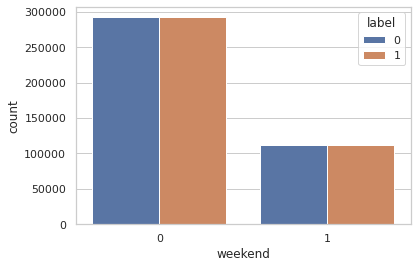

In [ ]:
sns.countplot(x='weekend', hue='label', data=eda_data )


باز هم همانطور که مشاهده می‌شود تعداد کامنت‌های کنایه‌آمیز و معمولی بر اساس اینکه در روز نوشته شده‌اند یا شب تفاوتی ندارند.

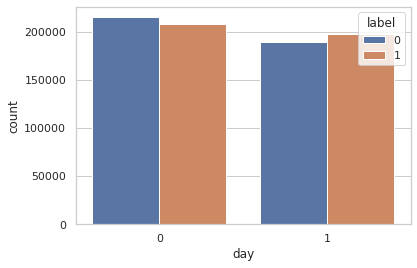

In [ ]:
sns.countplot(x='day', hue='label', data=eda_data )


همانطور که مشاهده می‌شود کلمات پرتکراری که در کامنت‌های کنایه‌آمیز و معمولی آمده اند تقریبا مثل هم هستند.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer_1 = CountVectorizer(stop_words='english', ngram_range=(1, 1))
vectorizer_2 = CountVectorizer(stop_words='english', ngram_range=(2, 2))
def freq_words(vectorizer, data):
    X = vectorizer.fit_transform(data)
    freqs = zip(vectorizer.get_feature_names(), np.asarray(X.sum(axis=0)).ravel())
    return sorted(freqs, key = lambda x: x[1], reverse=True)[:10]
l = [freq_words(vectorizer_1, data_copy[data_copy['label']==1]['comment']),
     freq_words(vectorizer_1, data_copy[data_copy['label']==0]['comment'])]
list(map(list, zip(*l)))

[[('just', 26265), ('like', 23818)],
 [('yeah', 25895), ('just', 22758)],
 [('like', 20873), ('don', 15325)],
 [('people', 17086), ('people', 12461)],
 [('don', 17078), ('think', 12343)],
 [('right', 12241), ('fuck', 9582)],
 [('know', 11586), ('good', 9478)],
 [('good', 10048), ('know', 9332)],
 [('sure', 9963), ('really', 8303)],
 [('yes', 9629), ('time', 8254)]]

همچنین در زیر بای‌گرام‌ها را در می‌بینیم.

In [ ]:
l = [freq_words(vectorizer_2, data_copy[data_copy['label']==1]['comment']),
     freq_words(vectorizer_2, data_copy[data_copy['label']==0]['comment'])]
list(map(list, zip(*l)))

[[('don know', 2264), ('fuck fuck', 5253)],
 [('sounds like', 1578), ('comcast comcast', 2674)],
 [('just like', 1474), ('looks like', 2099)],
 [('good thing', 1323), ('don know', 1775)],
 [('looks like', 1148), ('don think', 1582)],
 [('white people', 977), ('jerry jerry', 1341)],
 [('don worry', 923), ('sounds like', 1281)],
 [('didn know', 895), ('iphone iphone', 1111)],
 [('oh yeah', 868), ('pretty sure', 1075)],
 [('black people', 826), ('liar liar', 1073)]]

استفاده از کامنت‌های پرنت هنوز معلوم نیست، برای مربوط کردن آن‌ها به کامنت از تابع زیر استفاده کردیم که درحقیقت به کلمات مشترک هر کامنت و کامنت پدر نگاه می‌کند و همانطور که در باکس‌پلات‌های زیر مشاهده می‌شود، این معیار فرق خاصی بین کامنت‌های کنایه‌آمیز و معمولی ایجاد نمی‌کند و به نظر استفاده از آن در مدل توجیه ندارد

In [ ]:
def find_intersection(comment, parent):
    comment_words = [x.strip(string.punctuation) for x in comment.lower().split()]
    parent_words = [x.strip(string.punctuation) for x in parent.lower().split()]
    intersection_words = [x for x in comment_words if x in parent_words]
    return len(intersection_words)/len(comment_words)

In [ ]:
data_copy['intersection'] = [find_intersection(x,y) for x,y in zip(data_copy['comment'], data_copy['parent_comment'])]

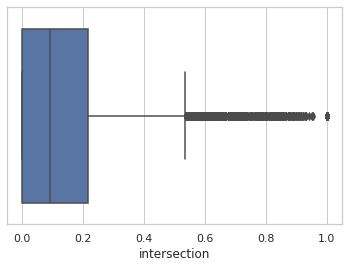

In [ ]:
sns.boxplot(x = data_copy[data_copy['label']==1]['intersection'])

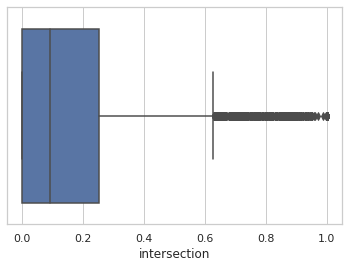

In [ ]:
sns.boxplot(x = data_copy[data_copy['label']==0]['intersection'])

#Splitting data into train set and validation set

Note: By data, we mean the training data which is splitted into train and validation set. Actuaaly I mean we have not yet used the test set.

Note: Here the selected feature is **Comments**.

In [ ]:
data.columns

Index(['Unnamed: 0', 'label', 'comment', 'author', 'subreddit', 'score', 'ups',
       'downs', 'date', 'created_utc', 'parent_comment'],
      dtype='object')

In [ ]:
train_data, validation_data, y_train, y_validation = train_test_split(data['comment'], data['label'], random_state=13)

In [ ]:
train_data.head()

212823         Monte's favorite ADC is Pilot tho
115414                          FFA shenanigans.
498307    792 IM rollan rollan rollan rollan WAH
221676                            Flair relevant
1902                       Yep, this is the one.
Name: comment, dtype: object

In [ ]:
y_train

212823    1
115414    0
498307    0
221676    1
1902      0
         ..
688994    1
256742    1
253456    1
702640    1
491858    0
Name: label, Length: 606748, dtype: int64

**Clouds**

Using clouds is a nice way for representation but it is not that much useful!
The more repetetive the word, the bigger in the cloud!

In [ ]:
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS,max_words = 500, max_font_size = 80,  random_state = 13, width=500, height=300)

Representing the sarcastic words

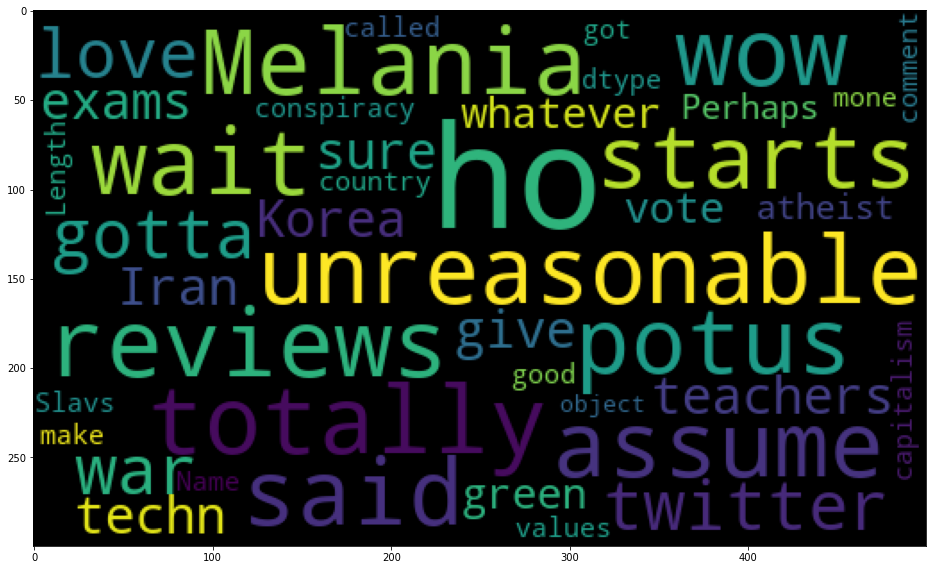

In [ ]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(data.loc[data['label'] == 1, 'comment']))
plt.imshow(wordcloud);

Representing non sarcastic words

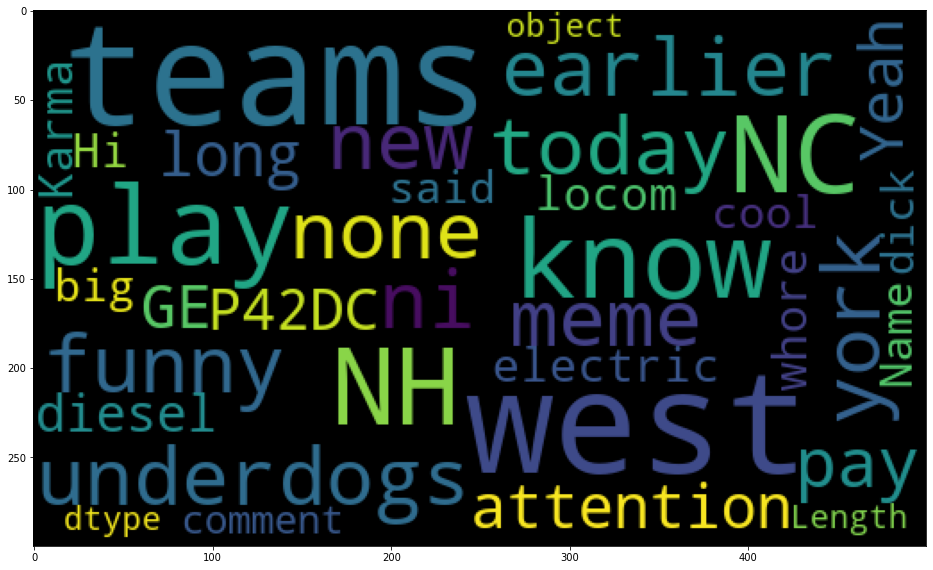

In [ ]:
plt.figure(figsize=(16, 12))
wordcloud.generate(str(data.loc[data['label'] == 0, 'comment']))
plt.imshow(wordcloud);

# Feature Engineering

We Should select the most dominant and main features that based on them the model can be able to predict the label (sarcastic or not) truely.

The three main features that help us in this way were:
(We actually could guess which features are more dominant intuietively and by instinct. The EDA certained us.)

1.   Comments : 
2.   Parent comments :
3.   Subreedits: This column has a very little effect on the result to be sarcastic or not and it is not that much infor mative in comparsion to two above columns but it is more informative than other ones.

Note: a column such as datث can be informative to show whether the text is sarcastic or not. For example if an special event occur in a special time,
then some regular terms will mean sarcastic but this case is rare and due to lack of RAM and also the huge training time needed for each column in complex models, we ignored the other columns such as date.



In [ ]:
train_data, validation_data, y_train, y_validation = train_test_split(data['comment'], data['label'], random_state=13)

# Models and Training

First all models are implemented for the first embedding method (TF-IDF).

Then all the models are implemented for the second embedding method (Word2vec).

# First Embedding method: TF IDF

TF : term frequency. It shows how much a term is repeatetive in a corpus.

IDF : 

**Confusion Matrix**

It showes: 

false positives: data which are labeled sarcastic, but they are not really sarcastic.

false negetive:  data which are labeled non sarcastic, but they are sarcastic.

true positive:  data which are labeled sarcastic, and they are sarcastic.

true negative:  data which are labeled non sarcastic, and they are not really sarcastic.

In [ ]:
#plot (normalized) confusion matrix
def plot_confusion_matrix(actual, predicted, classes, normalize):
    title='Confusion Matrix'
    figsize=(4,4)
    cmap=plt.cm.Purples
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')
    

**Model: Logistic Regression ---> comment Column** 

As predicted, logistic regression model is fast. It is a simple model with proper generalization which prevent data from overfitting. It has low variance because it is general and does not vary from one dataset to another. It has relatively high bais but seems reasonable, means that it is not exact or highly accurated but not that much error to prevent us using the model.

The training phase finished at about 30 seconds for whole data. It does not have that much accuracy and it reached about 70 percent in F1 score in both train and test phases (test phase is in next sections). 

In [ ]:
train_data, validation_data, y_train, y_validation = train_test_split(data['comment'], data['label'], random_state=13)

In [ ]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

In [ ]:
# multinomial logistic regression a.k.a softmax classifier
model = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', random_state=13, verbose=1)

In [ ]:
# sklearn's pipeline
model_pipeline = Pipeline([('tf_idf', tf_idf), ('logit', model)])

In [ ]:
model_pipeline.fit(train_data, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   11.0s finished


Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=50000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logit',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scali

In [ ]:
validation_prediction = model_pipeline.predict(validation_data)

**Validation Evaluation**

It is said to calculate F1 score as the metric.
The F1 score is calculated in this way:
F1 = tp / (tp +  0.5 * (fp+fn))

In [ ]:
#evaluating the logistic regression model on the validation data, not the test data
train_f1_score = f1_score(y_validation, validation_prediction)
print(train_f1_score)

0.7070449506664005


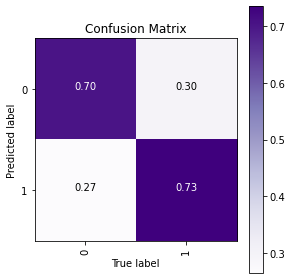

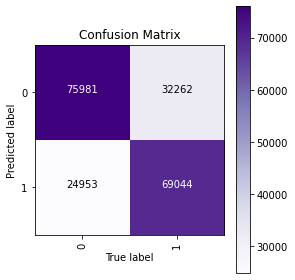

In [ ]:
plot_confusion_matrix(y_validation, validation_prediction, model_pipeline.named_steps['logit'].classes_ , normalize = True)
plot_confusion_matrix(y_validation, validation_prediction, model_pipeline.named_steps['logit'].classes_ , normalize = False)

As we can see, the matrix is balanced itself and it did not need any more preprocess.

**Weight Assignment**

Actually some words are sign of sarcasim, such as "yeah fuck!".

Each word is somehow a sign of sarcasm so we assign to all the words a weight which show how much sarcastic is it.

Positive values define sarcasim and negetive values means that the word does not have any other meaning than its real one.

In [ ]:
eli5.show_weights(estimator=model_pipeline.named_steps['logit'],vec=model_pipeline.named_steps['tf_idf'])

Weight?,Feature
+9.680,yes because
+7.671,clearly
+7.411,obviously
+6.868,yeah because
+6.811,totally
+6.143,because
+5.411,good thing
+5.153,duh
+5.053,gee
+4.978,but thought


**First Model: Logistic Regression ---> parrent Column**

As we saw in EDA and predicted, the comment column is more informatie and general to
find sarcastic words or phrases.

Here the F1 score is less than previous F1 score. Since the only difference between 
these two models is just selecting the train column, between comment or parent_comment columns,
we can say that our guess that comment column is more informative than others is proven. 

In [ ]:
train_data, validation_data, y_train, y_validation = train_test_split(data['parent_comment'], data['label'], random_state=13)

In [ ]:
model_pipeline.fit(train_data, y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:   13.6s finished


Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=50000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('logit',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scali

In [ ]:
validation_prediction = model_pipeline.predict(validation_data)

In [ ]:
#evaluating the logistic regression model on the validation data, not the test data
train_f1_score = f1_score(y_validation, validation_prediction)
print(train_f1_score)

0.5757637871644761


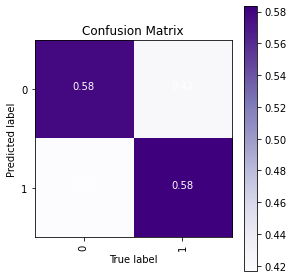

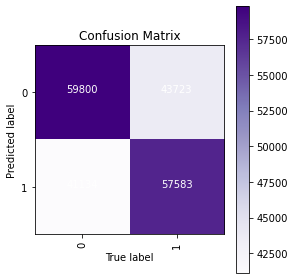

In [ ]:
plot_confusion_matrix(y_validation, validation_prediction, model_pipeline.named_steps['logit'].classes_ , normalize = True)
plot_confusion_matrix(y_validation, validation_prediction, model_pipeline.named_steps['logit'].classes_ , normalize = False)

In [ ]:
eli5.show_weights(estimator=model_pipeline.named_steps['logit'],vec=model_pipeline.named_steps['tf_idf'])

Weight?,Feature
+5.338,sarcasm
+3.338,sarcastic
+2.501,raped
+2.482,60fps
+2.414,racism
+2.360,fault
+2.295,who think
+2.254,vaccinated
+2.236,but hey
+2.192,but but


**Test Evaluation For logestic regression**

Now we test the logistic regression model on the test set.

We just test the logit model implemented on comment column with higher f1 score. 

Actually it is extra since this was not the best model with
highest f1 score to test.

In [ ]:
new_data = pd.read_csv('sarcasm_test_set.csv')

In [ ]:
new_data.head()

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...
1,11,0,Damn I was hoping God was real,Kvetch__22,baseball,14,-1,-1,2016-10,2016-10-28 09:07:50,James Shields Will Not Exercise Opt-Out Clause
2,27,0,This would make me cry.,neutralneutrals,AskReddit,1,-1,-1,2016-11,2016-11-07 12:03:16,"""You are like the end piece of bread in a loaf..."
3,28,0,At first I thought it was instructions on fixi...,Soperos,WTF,1,-1,-1,2016-10,2016-10-30 19:52:04,Found this under a box of porno mags well clea...
4,37,0,My stuffed animal I've had since I was born.,kn1820,AskReddit,1,-1,-1,2016-10,2016-10-11 11:17:42,Your house is burning down and you only have t...


In [ ]:
new_data.dropna(subset=['comment'], inplace=True)

In [ ]:
test_data = new_data['comment']
y_test = new_data ['label']

In [ ]:
test_prediction = model_pipeline.predict(test_data)

In [ ]:
#evaluating the logistic regression model on the test data
test_f1_score = f1_score(y_test, test_prediction)
print(test_f1_score)

0.7059538775426087


Fortunetal, the model has the same f1 score in both train and test phases and the 70 percent is OK, not that much error and no overfitting.

**Second Training model : SVM ---> on comment column**

Actually we knew that SVM is not the best model that can be fitted to the data, and because it took a long long long time to fit to the data (because the SVM algorithm is complicated ) we just get a little sample of data to train the model and see if it has good f1 score on validation (even in the little sample data), then it would be paased to the test phase.

The SVM f1 score is a little bit higher than simple models such as logistic regression but it took a lot of time and it is slow.

The f1 score differs from one set of parameters to another, and we print the best parameters of SVM model fitted to the data.

In [ ]:
sample_data = data.head(data.shape[0]//3)

In [ ]:
print(sample_data.shape)

(269653, 11)


In [ ]:
train_data, validation_data, y_train, y_validation = train_test_split(sample_data['comment'], sample_data['label'], random_state=13)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
# sklearn's pipeline
#parameters
parameters = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1], 'gamma':[0.1, 1]}
model = svm.SVC()
model = GridSearchCV(model, parameters, n_jobs=-1)
model_pipeline = Pipeline([('tf_idf', tf_idf), ('grid_svm', model)])
model_pipeline.fit(train_data, y_train)

Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=50000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern...
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                

In [ ]:
validation_prediction = model_pipeline.predict(validation_data)

In [ ]:
print('best_parameters for the SVM model:', model.best_params_)

best_parameters for the SVM model: {'C': 1, 'gamma': 0.1, 'kernel': 'linear'}


**Train Evaluation**  of SVM on comment column 

In [ ]:
#evaluating the SVM on the validation data, not the test data
train_f1_score = f1_score(y_validation, validation_prediction)
print(train_f1_score)

0.7101


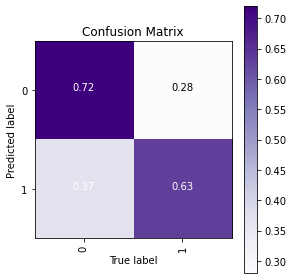

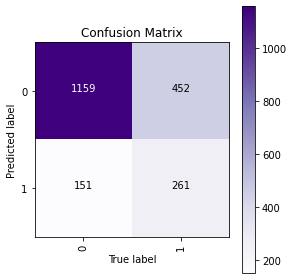

In [ ]:
plot_confusion_matrix(y_validation, validation_prediction, model_pipeline.named_steps['grid_svm'].classes_ , normalize = True)
plot_confusion_matrix(y_validation, validation_prediction, model_pipeline.named_steps['grid_svm'].classes_ , normalize = False)

**Second Training model : SVM ---> on prant_comment column**

In [ ]:
sample_data = data.head(data.shape[0]//3)

Like before (in logistic regression model) and like any other model in the following, the f1 score and other measures in the parent_comment column is less than the comment column.

In [ ]:
train_data, validation_data, y_train, y_validation = train_test_split(sample_data['parent_comment'], sample_data['label'], random_state=13)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn import svm
# sklearn's pipeline
#parameters
parameters = {'kernel': ['linear', 'rbf'], 'C': [0.1, 1], 'gamma':[0.1, 1]}
model = svm.SVC()
model = GridSearchCV(model, parameters, n_jobs=-1)
model_pipeline = Pipeline([('tf_idf', tf_idf), ('grid_svm', model)])
model_pipeline.fit(train_data, y_train)

Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=50000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern...
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                

In [ ]:
validation_prediction = model_pipeline.predict(validation_data)

In [ ]:
print('best_parameters for the SVM model:', model.best_params_)

best_parameters for the SVM model: {'C': 1, 'gamma': 1, 'kernel': 'rbf'}


In [ ]:
#evaluating the SVM on the validation data, not the test data
train_f1_score = f1_score(y_validation, validation_prediction)
print(train_f1_score)

0.4807


As expected the f1 score on this column is less than comment column and it is less informative.

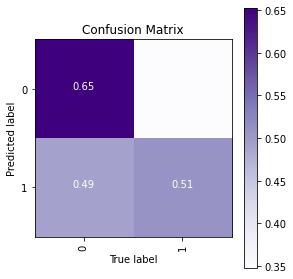

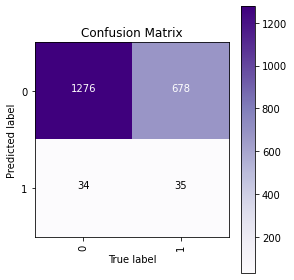

In [ ]:
plot_confusion_matrix(y_validation, validation_prediction, model_pipeline.named_steps['grid_svm'].classes_ , normalize = True)
plot_confusion_matrix(y_validation, validation_prediction, model_pipeline.named_steps['grid_svm'].classes_ , normalize = False)

**Third Training Model : Nueral Network (Multilayer Perceptron) --> on the comment column**

In [ ]:
sample_data = data.head(data.shape[0]//3)

In [ ]:
train_data, validation_data, y_train, y_validation = train_test_split(sample_data['comment'], sample_data['label'], random_state=13)

In [ ]:
# build bigrams, put a limit on maximal number of features and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

#find best values for hyper-parameters
parameters = {'solver': ['adam'], 'activation': ['tanh', 'logistic'], 'max_iter': [1000, 1500], 'alpha': 10.0 ** -np.arange(0, 3), 'hidden_layer_sizes':np.arange(30, 60, 5), 'random_state':[0]}
model = MLPClassifier()
model = GridSearchCV(model, parameters, n_jobs=-1)
model_pipeline = Pipeline([('tf_idf', tf_idf), ('nueral_network', model)])
model_pipeline.fit(train_data, y_train)

Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=50000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern...
                                                      validation_fraction=0.1,
                                                      verbose=False,
                                                      warm_start=False),
                              iid='deprecated', n_jobs=-1,
                      

Here we tried 

In [ ]:
validation_prediction = model_pipeline.predict(validation_data)

In [ ]:
print('best_parameters for the NN model:', model.best_params_)

best_parameters for the NN model: {'activation': 'tanh', 'alpha': 1.0, 'hidden_layer_sizes': 30, 'max_iter': 1000, 'random_state': 0, 'solver': 'adam'}


In [ ]:
#evaluating the NN on the validation data, not the test data
train_f1_score = f1_score(y_validation, validation_prediction)
print(train_f1_score)

0.689801


Due to lack of time and RAM we used one third of data to train the model.

By training the model with whole the data, there would be a little bit increase in model f1 score because maybe larger dataset mey lead to less bias (by the intuition to data,not that much variance)

We expected this model to be more accurate, but as mentioned above the reason is lack of RAM and time to train it. But we will test it on the test data set too.

**Third Training Model : Nueral Network (Multilayer Perceptron) --> on the parent_comment column**

In [ ]:
sample_data = data.head(data.shape[0]//2000)
train_data, validation_data, y_train, y_validation = train_test_split(sample_data['parent_comment'], sample_data['label'], random_state=13)
# build bigrams, put a limit on maximal number of features and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier

#find best values for hyper-parameters
parameters = {'solver': ['adam'], 'activation': ['tanh', 'logistic'], 'max_iter': [1000, 1500], 'alpha': 10.0 ** -np.arange(0, 3), 'hidden_layer_sizes':np.arange(30, 60, 5), 'random_state':[0]}
model = MLPClassifier()
model = GridSearchCV(model, parameters, n_jobs=-1)
model_pipeline = Pipeline([('tf_idf', tf_idf), ('nueral_network', model)])
model_pipeline.fit(train_data, y_train)

Pipeline(memory=None,
         steps=[('tf_idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=50000,
                                 min_df=2, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern...
                                                      validation_fraction=0.1,
                                                      verbose=False,
                                                      warm_start=False),
                              iid='deprecated', n_jobs=-1,
                      

In [ ]:
validation_prediction = model_pipeline.predict(validation_data)

In [ ]:
print('best_parameters for the NN model:', model.best_params_)

best_parameters for the NN model: {'activation': 'tanh', 'alpha': 1.0, 'hidden_layer_sizes': 30, 'max_iter': 1000, 'random_state': 0, 'solver': 'adam'}


In [ ]:
#evaluating the NN on the validation data, not the test data
train_f1_score = f1_score(y_validation, validation_prediction)
print(train_f1_score)

0.5003


As predicted, the best model is nueral network which has the most complexity and is the slowest, but reach the best f1 score. We tried different parameters for the model and print the best parameters in each case ( both for comment and for parent_comment columns)

**Forth Training Model : KNN --> on comment column**


In [ ]:
sample_data = data.head(data.shape[0]//3)
train_data, validation_data, y_train, y_validation = train_test_split(sample_data['comment'], sample_data['label'], random_state=13)
# build bigrams, put a limit on maximal number of features and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

In [ ]:
parameters = {'k': [2, 5, 10 ,20, 50, 100, 500, 1000, 5000]}
from sklearn.neighbors import KNeighborsClassifier
for k in parameters['k']:
  model = KNeighborsClassifier(n_neighbors=k)
  model_pipeline = Pipeline([('tf_idf', tf_idf), ('knn', model)])
  model_pipeline.fit(train_data, y_train)
  validation_prediction = model_pipeline.predict(validation_data)
  train_f1_score = f1_score(y_validation, validation_prediction)
  print(train_f1_score)

0.31247799627822764
0.3245573667256037
0.20166261380987388
0.14810190552632363
0.08598270391339513
0.056916243654822334
0.03553756185335132
0.030158525583193714
0.0


The knn algorithm is the k nearest neighbours algorithm that in each iteration, we see between the k nearest neighbours of the data in the vector space and see their current label. We assign the majority label of the neighbors to the data.

As expected before, the KNN model with different Ks (k is the number of nearest neighbours) is not that much accurate but it is somehow fast. We tried different ks and as shown above, the f1 score varies.

This model has low f1 score which mans it has high bias (error) but it doen not lead to overfitting and has low variance (the model is generalized and the results does not vary from one dataset to another).

The model is the not that much good even on the comment column which is expected to lead to highest accuracy.

As we can see, the more the k ,the less the f1 score.

**Forth Training Model : KNN --> on parent_comment column**


Because we knew that the parent_column is not as informative as comment column, and we found the best approximate k in the knn algorithm for comment column, assuming that these best parameters does not vary from a column to another, we just tried the knn model with the best k obtained from comment column.

In [ ]:
sample_data = data.head(data.shape[0]//3)
train_data, validation_data, y_train, y_validation = train_test_split(sample_data['comment'], sample_data['label'], random_state=13)
# build bigrams, put a limit on maximal number of features and minimal word frequency
tf_idf = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=2)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=k)
model_pipeline = Pipeline([('tf_idf', tf_idf), ('knn', model)])
model_pipeline.fit(train_data, y_train)
validation_prediction = model_pipeline.predict(validation_data)
train_f1_score = f1_score(y_validation, validation_prediction)
print(train_f1_score)

**Fifth Training Model : Recurrent --> on comment column**


This the densed nueral network. The whole description about this model is:

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding
model = Sequential()
# Embedding layer
model.add(
    Embedding(input_dim=num_words,
              input_length = training_length,
              output_dim=100,
              weights=[embedding_matrix],
              trainable=False,
              mask_zero=True))

# Masking layer for pre-trained embeddings
model.add(Masking(mask_value=0.0))

# Recurrent layer
model.add(LSTM(64, return_sequences=False, 
               dropout=0.1, recurrent_dropout=0.1))

# Fully connected layer
model.add(Dense(64, activation='relu'))

# Dropout for regularization
model.add(Dropout(0.5))

# Output layer
model.add(Dense(num_words, activation='softmax'))

# Compile the model
model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Load in embeddings
glove_vectors = '/home/ubuntu/.keras/datasets/glove.6B.100d.txt'
glove = np.loadtxt(glove_vectors, dtype='str', comments=None)
# Extract the vectors and words
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

# Create lookup of words to vectors
word_lookup = {word: vector for word, vector in zip(words, vectors)}

# New matrix to hold word embeddings
embedding_matrix = np.zeros((num_words, vectors.shape[1]))

for i, word in enumerate(word_idx.keys()):
    # Look up the word embedding
    vector = word_lookup.get(word, None)

    # Record in matrix
    if vector is not None:
        embedding_matrix[i + 1, :] = vector

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Create callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             ModelCheckpoint('../models/model.h5'), save_best_only=True, 
                             save_weights_only=False)]

In [ ]:
history = model.fit(X_train,  y_train, 
                    batch_size=2048, epochs=150,
                    callbacks=callbacks,
                    validation_data=(X_valid, y_valid))

In [ ]:
from keras import load_model
# Load in model and evaluate on validation data
model = load_model('../models/model.h5')
model.evaluate(X_valid, y_valid)

In [ ]:
pip install gensim==3.7.0

     |████████████████████████████████| 24.2MB 124kB/s 
  Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


# Word2vec

We can convert senteces to numerical vectors using 'Word2Vec'. It's based on Neural Network models. 
We represent each word in a space by means of its neighbors. The meaning of each word is related to its neighbors in a sentence.
Two methods:


1.   Continuous Bag of Word (CBOW)
2.   Skip-gram

After representing each word by a vector, we can use these vectors to embed sentences:


1.   Calculating Mean of word vectors
2.   Using tf-idf weight for calculating mean 





## Comment

First, we use 'word2vec' for 'comment' feature.

### preprocess

In [ ]:
!pip install eli5
!pip install gensim==3.7.0

In [ ]:
import nltk
import re
from collections import defaultdict
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

Creating a list of lists containing 'comment' sentences for each row:

In [ ]:
df1 = data[['comment']]
df2 = df1.apply(lambda x: ','.join(x.astype(str)), axis=1)
df_clean = pd.DataFrame({'clean': df2})
sent = [row.split(',') for row in df_clean['clean']]
sent[:2] # 49

[['NC and NH.'],
 ['You do know west teams play against west teams more than east teams right?']]

Preprocessing the texts:


*   tokenizing
*   stemming
*   lemmatization



In [ ]:
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = text.split()    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    return text

Removing 'stop words' like '[the, am, i, ...]' as noninformative terms:

In [ ]:
nltk.download("stopwords")
lst_stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
data["comment_clean"] = data["comment"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords)) # 46s
data.head()

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comment_clean
0,0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",nc nh
1,1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,know west team play west team east team right
2,2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,underdog earlier today since gronks announceme...
3,3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,meme isnt funny none new york nigga one
4,5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?,dont pay attention long shes legal wouldnt kic...


Splitting dataset into train and test (validation):

In [ ]:
## split dataset
dtf_train, dtf_test = train_test_split(data, test_size=0.3)
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [ ]:
dtf_train.head()

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comment_clean
335547,419165,1,You should have asked them to RMA you a sennhe...,Magic_Sloth,pcmasterrace,-2,-2,0,2016-02,2016-02-25 14:52:24,"Thank you Logitech, for replacing my broken ye...",asked rma sennheiser headphone equal greater v...
785904,982060,0,Do you have any other lyrics?,ladymerc,actuallesbians,3,3,0,2013-05,2013-05-18 16:57:47,apples and oranges bananas and grapes somebody...,lyric
724632,905340,0,"Also, you will put things away, before your br...",proweruser,AskReddit,1,1,0,2013-10,2013-10-28 19:04:32,I can almost assure you that it does. I cannot...,also put thing away brain notice putting thus ...
134764,168365,1,You don't say!,Omni_Devil,titanfall,0,-1,-1,2016-12,2016-12-02 14:26:25,The thing is though that both weapons are free...,dont say
752422,940115,1,"Yeah, Dobson and KT really need to show up, it...",nihoyminioy,Patriots,2,2,0,2013-12,2013-12-09 18:29:15,Things the Pats need to fix for a playoff run ...,yeah dobson kt really need show like werent ev...


Creating word2vec embedding by capturing unigrams, bigrams and trigrams in sentences:

In [ ]:
corpus = dtf_train["comment_clean"]
## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1])
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)
## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector) # 1m 8s

We use 'skip-gram' instead of 'bag of words' as it's usually better!

In [ ]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1,) # 3m 6s

Now each word has a 300 dim representation in new space. Words that tend to be neighbours will be similar in this space.

In [ ]:
nlp["data"].shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


(300,)

In [ ]:
w2v = dict(zip(nlp.wv.index2word, nlp.wv.syn0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


We can use w2v in two ways to change 'comment' representation as vectors:

*   For each 'comment', we can use mean of word vectors (MeanEmbedding)
*   We can use tf-idf weights, when calculating mean of w2v vectors (TfIdfEmbedding)



In [ ]:
class MeanW2VEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec[list(word2vec.keys())[0]])

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [ ]:
class TfidfW2VEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec[list(word2vec.keys())[0]])

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

### Logistic Regression

We start traning logistic regression model on both representation methods (mean, tf-idf):

In [ ]:
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', random_state=13, verbose=1)

logit_w2v = Pipeline([
    ("word2vec vectorizer with mean", MeanW2VEmbeddingVectorizer(w2v)),
    ("logit", logit)])
logit_w2v_tfidf = Pipeline([
    ("word2vec vectorizer with tf-idf", TfidfW2VEmbeddingVectorizer(w2v)),
    ("logit", logit)])

In [ ]:
logit_w2v.fit(dtf_train["comment_clean"], y_train) # 8m 44s

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:  8.4min finished


Pipeline(memory=None,
         steps=[('word2vec vectorizer with mean',
                 <__main__.MeanW2VEmbeddingVectorizer object at 0x7f204dd5ba50>),
                ('logit',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=4, penalty='l2',
                                    random_state=13, solver='lbfgs', tol=0.0001,
                                    verbose=1, warm_start=False))],
         verbose=False)

In [ ]:
validation_prediction = logit_w2v.predict(dtf_test["comment_clean"])

f1-score on validation set:

In [ ]:
#evaluating the logistic regression model on the validation data, not the test data
train_f1_score = f1_score(y_test, validation_prediction)
print(train_f1_score)

0.5778347404266734


Confusion matrix:

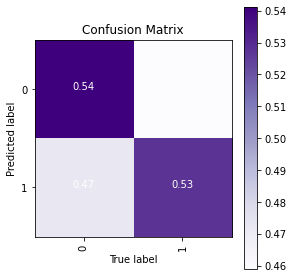

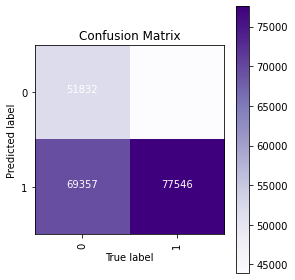

In [ ]:
plot_confusion_matrix(y_test, validation_prediction, logit_w2v.named_steps['logit'].classes_ , normalize = True)
plot_confusion_matrix(y_test, validation_prediction, logit_w2v.named_steps['logit'].classes_ , normalize = False)

Using Word2vec and tf-idf



In [ ]:
logit_w2v_tfidf.fit(dtf_train["comment_clean"], y_train) # 11m 10s

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed: 10.1min finished


Pipeline(memory=None,
         steps=[('word2vec vectorizer with tf-idf',
                 <__main__.TfidfW2VEmbeddingVectorizer object at 0x7f204dd51cd0>),
                ('logit',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=4, penalty='l2',
                                    random_state=13, solver='lbfgs', tol=0.0001,
                                    verbose=1, warm_start=False))],
         verbose=False)

In [ ]:
y_test = dtf_test["label"].values

In [ ]:
validation_prediction = logit_w2v_tfidf.predict(dtf_test["comment_clean"])

f1-score on validation set:

In [ ]:
#evaluating the logistic regression model on the validation data, not the test data
train_f1_score = f1_score(y_test, validation_prediction)
print(train_f1_score)

0.5777405421507299


Confusion matrix:

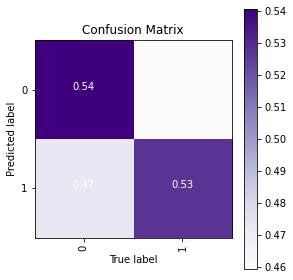

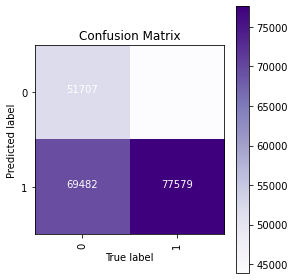

In [ ]:
plot_confusion_matrix(y_test, validation_prediction, logit_w2v_tfidf.named_steps['logit'].classes_ , normalize = True)
plot_confusion_matrix(y_test, validation_prediction, logit_w2v_tfidf.named_steps['logit'].classes_ , normalize = False)

### SVM

Next model is SVM:

In [ ]:
svm = SVC(C=1.0, kernel='rbf', max_iter=1000)

svm_w2v = Pipeline([
    ("word2vec vectorizer with mean", MeanW2VEmbeddingVectorizer(w2v)),
    ("svm", svm)])

In [ ]:
svm_w2v.fit(dtf_train["comment_clean"], y_train) # 11m 52s

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('word2vec vectorizer with mean',
                 <__main__.MeanW2VEmbeddingVectorizer object at 0x7f201e1ef210>),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=1000,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
validation_prediction = svm_w2v.predict(dtf_test["comment_clean"]) # 4m 5s

f1-score on validation set: (best model on word2vec embedding)

In [ ]:
#evaluating the logistic regression model on the validation data, not the test data
train_f1_score = f1_score(y_test, validation_prediction)
print(train_f1_score)

0.6693156757325128


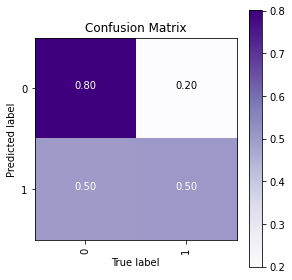

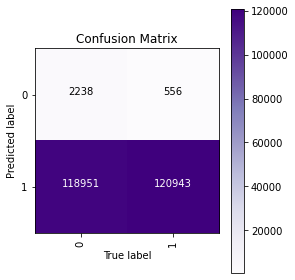

In [ ]:
plot_confusion_matrix(y_test, validation_prediction, svm_w2v.named_steps['svm'].classes_ , normalize = True)
plot_confusion_matrix(y_test, validation_prediction, svm_w2v.named_steps['svm'].classes_ , normalize = False)

We try again with larger max_iter parameter:

In [ ]:
svm = SVC(C=1.0, kernel='rbf', max_iter=2000)

svm_w2v = Pipeline([
    ("word2vec vectorizer with mean", MeanW2VEmbeddingVectorizer(w2v)),
    ("svm", svm)])

In [ ]:
svm_w2v.fit(dtf_train["comment_clean"], y_train) # 22m 52s

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('word2vec vectorizer with mean',
                 <__main__.MeanW2VEmbeddingVectorizer object at 0x7f201ed86950>),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=2000,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
validation_prediction = svm_w2v.predict(dtf_test["comment_clean"]) # 8m 21s

f1-score is almost the same as last one:

In [ ]:
#evaluating the logistic regression model on the validation data, not the test data
train_f1_score = f1_score(y_test, validation_prediction)
print(train_f1_score)

0.6692260671621355


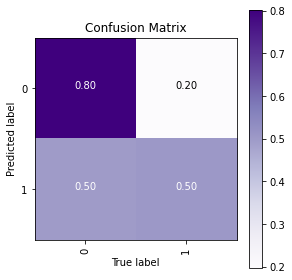

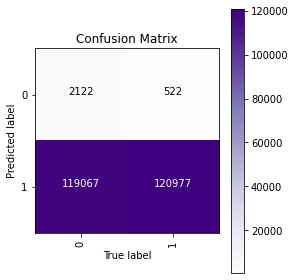

In [ ]:
plot_confusion_matrix(y_test, validation_prediction, svm_w2v.named_steps['svm'].classes_ , normalize = True)
plot_confusion_matrix(y_test, validation_prediction, svm_w2v.named_steps['svm'].classes_ , normalize = False)

### Neural Network

Neural Network model with two hidden layers of size 10:

In [ ]:
nn_w2v = Pipeline(steps=[
    ("word2vec vectorizer with mean", MeanW2VEmbeddingVectorizer(w2v)),
    ("nn", MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, activation="logistic"))])

In [ ]:
nn_w2v.fit(dtf_train["comment_clean"], y_train) # 4m 21s

Pipeline(memory=None,
         steps=[('word2vec vectorizer with mean',
                 <__main__.MeanW2VEmbeddingVectorizer object at 0x7f201f96ec10>),
                ('nn',
                 MLPClassifier(activation='logistic', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(10, 10),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=1000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [ ]:
validation_prediction = nn_w2v.predict(dtf_test["comment_clean"]) # 8m 21s

f1-score on validation set:

In [ ]:
#evaluating the logistic regression model on the validation data, not the test data
train_f1_score = f1_score(y_test, validation_prediction)
print(train_f1_score)

0.5917260883044606


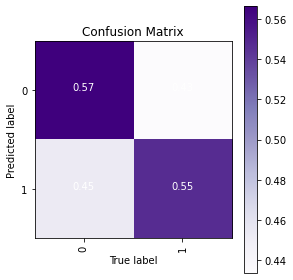

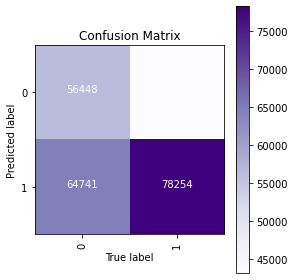

In [ ]:
plot_confusion_matrix(y_test, validation_prediction, nn_w2v.named_steps['nn'].classes_ , normalize = True)
plot_confusion_matrix(y_test, validation_prediction, nn_w2v.named_steps['nn'].classes_ , normalize = False)

Neural Network with one hidden layer of size 100:

In [ ]:
nn_w2v = Pipeline(steps=[
    ("word2vec vectorizer with mean", MeanW2VEmbeddingVectorizer(w2v)),
    ("nn", MLPClassifier(hidden_layer_sizes=(100), max_iter=1000, activation="logistic"))])

This model takes longer to train than last one:

In [ ]:
nn_w2v.fit(dtf_train["comment_clean"], y_train) # 12m 18s

Pipeline(memory=None,
         steps=[('word2vec vectorizer with mean',
                 <__main__.MeanW2VEmbeddingVectorizer object at 0x7f20206ec450>),
                ('nn',
                 MLPClassifier(activation='logistic', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=100, learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=1000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

f1-score is almost the same:

In [ ]:
#evaluating the logistic regression model on the validation data, not the test data
train_f1_score = f1_score(y_test, validation_prediction)
print(train_f1_score)

0.5917260883044606


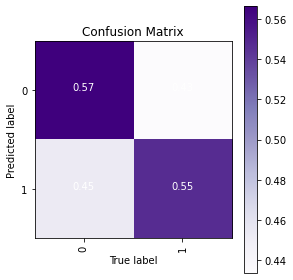

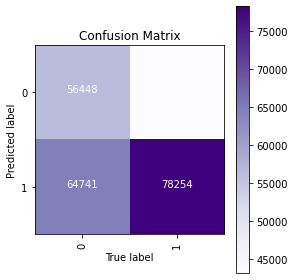

In [ ]:
plot_confusion_matrix(y_test, validation_prediction, nn_w2v.named_steps['nn'].classes_ , normalize = True)
plot_confusion_matrix(y_test, validation_prediction, nn_w2v.named_steps['nn'].classes_ , normalize = False)

## parent_comment

Now we try to use embedding on 'parent_comment' column:

### preprocess

Preprocessing and creating w2v word representation:

In [ ]:
df1 = data[['parent_comment']]
df2 = df1.apply(lambda x: ','.join(x.astype(str)), axis=1)
df_clean = pd.DataFrame({'clean': df2})
sent = [row.split(',') for row in df_clean['clean']]
sent[:2] # 49

[['Yeah',
  ' I get that argument. At this point',
  " I'd prefer is she lived in NC as well."],
 ['The blazers and Mavericks (The wests 5 and 6 seed) did not even carry a good enough record to make the playoffs in the east last year.']]

In [ ]:
data["parent_comment_clean"] = data["parent_comment"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords)) # 1m 39s
data.head()

,Unnamed: 0,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment,comment_clean,parent_comment_clean
0,0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ...",nc nh,yeah get argument point id prefer lived nc well
1,1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...,know west team play west team east team right,blazer maverick west 5 6 seed even carry good ...
2,2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.,underdog earlier today since gronks announceme...,theyre favored win
3,3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz,meme isnt funny none new york nigga one,deadass dont kill buzz
4,5,0,"I don't pay attention to her, but as long as s...",only7inches,AskReddit,0,0,0,2016-09,2016-09-02 10:35:08,do you find ariana grande sexy ?,dont pay attention long shes legal wouldnt kic...,find ariana grande sexy


In [ ]:
## split dataset
dtf_train, dtf_test = train_test_split(data, test_size=0.3)
y_train = dtf_train["label"].values
y_test = dtf_test["label"].values

In [ ]:
corpus = dtf_train["parent_comment_clean"]
## create list of lists of unigrams
lst_corpus = []
for string in corpus:
   lst_words = string.split()
   lst_grams = [" ".join(lst_words[i:i+1])
               for i in range(0, len(lst_words), 1)]
   lst_corpus.append(lst_grams)
## detect bigrams and trigrams
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, 
                 delimiter=" ".encode(), min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
            delimiter=" ".encode(), min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector) # 2m 36s

In [ ]:
nlp = gensim.models.word2vec.Word2Vec(lst_corpus, size=300,   
            window=8, min_count=1, sg=1,) # 8m 14s

In [ ]:
w2v = dict(zip(nlp.wv.index2word, nlp.wv.syn0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


### logistic regression

Training logistic regression model:

In [ ]:
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=1, n_jobs=4, solver='lbfgs', random_state=13, verbose=1)

logit_w2v = Pipeline([
    ("word2vec vectorizer with mean", MeanW2VEmbeddingVectorizer(w2v)),
    ("logit", logit)])
logit_w2v_tfidf = Pipeline([
    ("word2vec vectorizer with tf-idf", TfidfW2VEmbeddingVectorizer(w2v)),
    ("logit", logit)])

In [ ]:
logit_w2v.fit(dtf_train["parent_comment_clean"], y_train) # 10m 40s

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed: 10.0min finished


Pipeline(memory=None,
         steps=[('word2vec vectorizer with mean',
                 <__main__.MeanW2VEmbeddingVectorizer object at 0x7f204e1c3a50>),
                ('logit',
                 LogisticRegression(C=1, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=4, penalty='l2',
                                    random_state=13, solver='lbfgs', tol=0.0001,
                                    verbose=1, warm_start=False))],
         verbose=False)

In [ ]:
validation_prediction = logit_w2v.predict(dtf_test["parent_comment_clean"])

f1-score on validation set:

In [ ]:
#evaluating the logistic regression model on the validation data, not the test data
train_f1_score = f1_score(y_test, validation_prediction)
print(train_f1_score)

0.5495870969741103


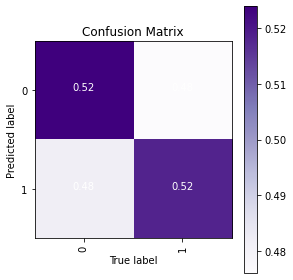

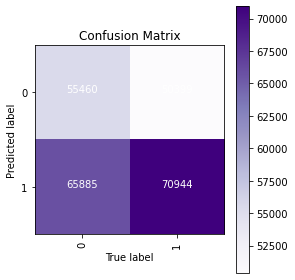

In [ ]:
plot_confusion_matrix(y_test, validation_prediction, logit_w2v.named_steps['logit'].classes_ , normalize = True)
plot_confusion_matrix(y_test, validation_prediction, logit_w2v.named_steps['logit'].classes_ , normalize = False)

### SVM

Training SVM:

In [ ]:
svm = SVC(C=1.0, kernel='rbf', max_iter=1000)

svm_w2v = Pipeline([
    ("word2vec vectorizer with mean", MeanW2VEmbeddingVectorizer(w2v)),
    ("svm", svm)])

SVM takes longer to train than other models.

In [ ]:
svm_w2v.fit(dtf_train["parent_comment_clean"], y_train) # 11m 42s

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


Pipeline(memory=None,
         steps=[('word2vec vectorizer with mean',
                 <__main__.MeanW2VEmbeddingVectorizer object at 0x7f2002bb8d10>),
                ('svm',
                 SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='rbf', max_iter=1000,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [ ]:
validation_prediction = svm_w2v.predict(dtf_test["parent_comment_clean"])

f1-score on validation set:

In [ ]:
#evaluating the logistic regression model on the validation data, not the test data
train_f1_score = f1_score(y_test, validation_prediction)
print(train_f1_score)

0.666386647507461


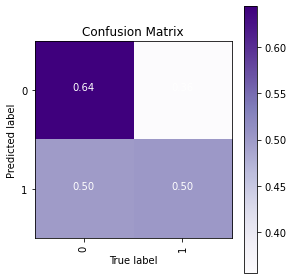

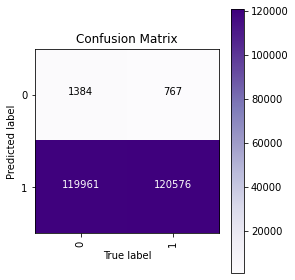

In [ ]:
plot_confusion_matrix(y_test, validation_prediction, svm_w2v.named_steps['svm'].classes_ , normalize = True)
plot_confusion_matrix(y_test, validation_prediction, svm_w2v.named_steps['svm'].classes_ , normalize = False)

### Neural Network

Training neural network with two hidden layers of 10 (best nn config for 'comment' column)

In [ ]:
nn_w2v = Pipeline(steps=[
    ("word2vec vectorizer with mean", MeanW2VEmbeddingVectorizer(w2v)),
    ("nn", MLPClassifier(hidden_layer_sizes=(10, 10), max_iter=1000, activation="logistic"))])

In [ ]:
nn_w2v.fit(dtf_train["parent_comment_clean"], y_train) # 2m 21s

Pipeline(memory=None,
         steps=[('word2vec vectorizer with mean',
                 <__main__.MeanW2VEmbeddingVectorizer object at 0x7f20016ed310>),
                ('nn',
                 MLPClassifier(activation='logistic', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=False, epsilon=1e-08,
                               hidden_layer_sizes=(10, 10),
                               learning_rate='constant',
                               learning_rate_init=0.001, max_fun=15000,
                               max_iter=1000, momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=None, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False))],
         verbose=False)

In [ ]:
validation_prediction = nn_w2v.predict(dtf_test["parent_comment_clean"])

f1-score on validation set:

In [ ]:
#evaluating the logistic regression model on the validation data, not the test data
train_f1_score = f1_score(y_test, validation_prediction)
print(train_f1_score)

0.5955745845689518


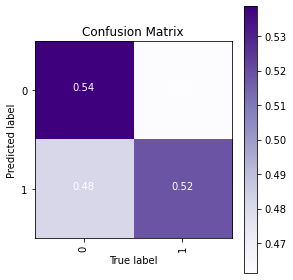

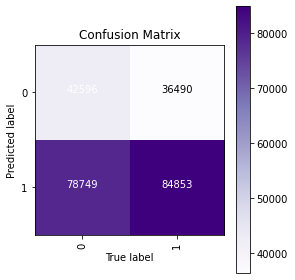

In [ ]:
plot_confusion_matrix(y_test, validation_prediction, nn_w2v.named_steps['nn'].classes_ , normalize = True)
plot_confusion_matrix(y_test, validation_prediction, nn_w2v.named_steps['nn'].classes_ , normalize = False)